# HW 1: Gaussian Processes

----------------------------------------------------
Machine Learning    

*Vanessa Gómez Verdejo vanessa@tsc.uc3m.es*, *Emilio Parrado Hernández emipar@tsc.uc3m.es* and *Pablo M. Olmos olmos@tsc.uc3m.es*

----------------------------------------------------


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In this first homework we are going to design our own class to train a GP. For simplicity we will consider that the model will always use gaussian kernel. For this, we will use pytorch as an optimizer that allows us to maximize the marginal likelihood and we will design a class with three methods:
.init(): where we initialize the model with the hyperparameters of the model, the width of the RBF kernel (gamma) and the standard deviation of the noise (sigma_n).
.fit(): where we learn the values of these parameters maximizing the marginal likelihood.
.predict(): where for a sample or set of test data we obtain its predictive distribution (mean and variance).

Para comenzar, testearemos esta clase sobre un toy problem unidimensional y luego lo testearemos sobre un dataset multidimensional.

# Data generation 1

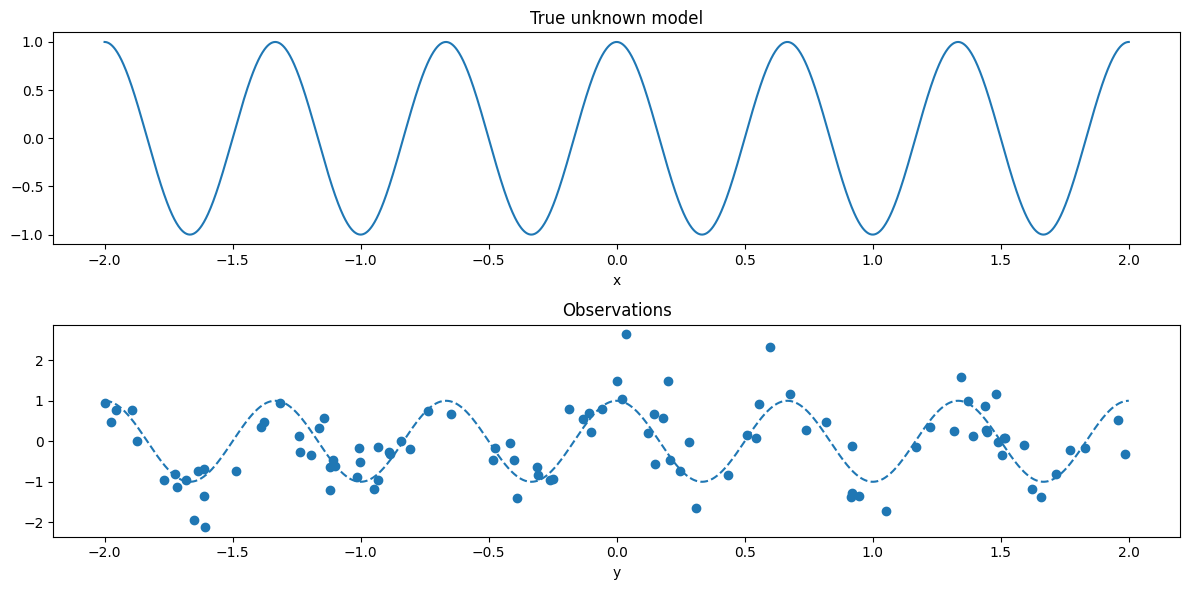

In [2]:
import random

# Uknown  generative model
def ff(x, a=1., b=3):
  return np.cos(b*np.pi*x)

random.seed(42)
def get_ff_observation(ff):
  sigma_n = 0.5
  # Change the data generation to analize the predictive variance with uniform samples in the interval [-2,2] vs. no unifrom
  x = random.uniform(-2,2)
  ee = random.gauss(mu=0, sigma=sigma_n)
  return x, ff(x) + ee

# Train samples
n=100
X=[]
Y=[]
for n in range(100):
  x,y = get_ff_observation(ff)
  X.append(x)
  Y.append(y)


# Data for plotting purposes
xg = np.linspace(-2,2,2000)

# Compute model outputs
y = ff(x)
yg = ff(xg)
s = 1 # Noise variance
y += np.array([random.gauss(mu=0, sigma=s) for ii in range(n)]) # Add noise over example samples
#my = np.mean(y)

fa, aa = plt.subplots(2,1,figsize=(12,6))
aa[0].plot(xg,yg,label='ff(x)')
aa[0].set_xlabel('x')
aa[0].set_title('True unknown model')
aa[1].scatter(X,Y)
aa[1].plot(xg,yg,linestyle='--',label='underlying ff(x)')
aa[1].set_xlabel('x')
aa[1].set_xlabel('y')
aa[1].set_title('Observations')

fa.tight_layout()

In [3]:
# Test samples
Xt = np.linspace(-2,2,2000)

# Compute model outputs
ft = ff(Xt)
s = 0.5
Yt = ft+ np.array([random.gauss(mu=0, sigma=s) for ii in range(Xt.shape[0])]) # Add noise over example samples


As the model implementation is going to work over torch tensors, let's convert our train/test variables.

In [4]:
import torch
X = torch.tensor(X)[:,None].double()
Y = torch.tensor(Y).double()
Xt = torch.tensor(Xt)[:,None].double()
Yt = torch.tensor(Yt).double()

# 2. Desing of the GP regressor

For the design of the GP regressor we provide you with the following code skeleton:

In [5]:
def RBF_kernel(X1,X2, gamma):
    K = torch.exp(-gamma * torch.cdist(X1, X2))
    return K


class GaussianProcess():
    def __init__(self):
          self.sigma_n = 1.0
          self.gamma = 1.0
          self.X = None
          self.Y = None

    def fit(self,X,Y):
      self.X = X
      self.Y = Y

      # FILL IN

    def predict(self, Xt, noisy = False):
      # FILL IN

      return my, sy


## 2.1 Predictive posterior

For simplicity, let's start by completing the .predict() method. Note that the GP predictive distribution can be calculated without parameter fitting (GP is a non-parametric method), so even though the .fit() is incomplete (right now it only stores the train data), predictions can be made for the gamma and sigma_n values.  So complete the predict function of the model and test the performance of the model using the default values of gamma and sigma_n.

Remember that .predict must implement for each test sample the following predictive distribution:

$$
p(\mathbf f_t | X_t,X,\mathbf y) = \mathcal N({\mathbf m}_t, V_t)
$$
where
$${\mathbf m}_t = \mathbf m(X_t)+K_t^\top (K+ \sigma_n^2\mathbf I)^{-1}(\mathbf y-\mathbf m(X))$$
$$V_t = K_{tt}-K_t^\top (K+ \sigma_n^2\mathbf I)^{-1} K_t$$

and if we need the noisy predictive variance
$$V_{t,noisy} = V_t + \sigma_n^2 \mathbf I$$

As $V_t$ or $V_{t,noisy} $ are the covariance matrix of all test samples, we will simplify the .predict() function returning the standard deviation of each test sample, that is, returning $sqrt(diag(V_{t,noisy}))$ or $sqrt(diag(V_{t}))$. Note that the testing cells are provided for you!


### SOLUTION

In [6]:
class GaussianProcess():
    def __init__(self):
          self.sigma_n = 1.0
          self.gamma = 1.0
          self.X = None
          self.Y = None

    def fit(self,X,Y):
      self.X = X
      self.Y = Y
      # FILL IN

    def predict(self,Xt, noisy = False):

      K = RBF_kernel(self.X,self.X, self.gamma)
      Kt = RBF_kernel(Xt,self.X, self.gamma)
      Ktt = RBF_kernel(Xt,Xt, self.gamma)


      sn2 = self.sigma_n ** 2
      iK = np.linalg.inv(K + sn2*torch.eye(self.X.shape[0]))

      my = Kt @ iK @ Y

      Sy = Ktt - Kt @ iK @ Kt.T
      sy = torch.sqrt(torch.diag(Sy) + sn2)
      if noisy:
        sy = torch.sqrt(torch.diag(Sy) + sn2)
      else:
        sy = torch.sqrt(torch.diag(Sy))
      return my, sy


In [7]:
myGP = GaussianProcess()
myGP.fit(X,Y)
mt, st = myGP.predict(Xt)

# Compute MSE error
MSE_tst = np.mean((Yt-mt).numpy()**2)
print(MSE_tst)


0.5666749584116845


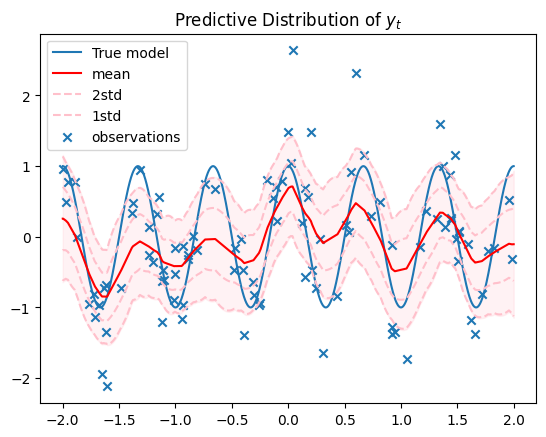

In [8]:
# Plot the predictive distribution
xt = np.squeeze(Xt.numpy())

plt.plot(xg,yg,label='True model')
plt.plot(xt,mt,label='mean',color='red')

plt.plot(xt,mt+1.96*st,label='2std',linestyle='--',color='pink')
plt.fill_between(xt, mt-2*st, mt+2*st,alpha=0.1,color='pink')
plt.plot(xt,mt-1.96*st,linestyle='--',color='pink')

plt.plot(xt,mt+st,label='1std',linestyle='--',color='pink')
plt.fill_between(xt, mt-2*st, mt+2*st,alpha=0.1,color='pink')
plt.plot(xt,mt-st,linestyle='--',color='pink')


plt.scatter(X,Y,marker='x',label='observations')
plt.title('Predictive Distribution of $y_t$')
plt.legend()

## 2.2 Learning model hyperparameters

Now we are going to cmplete the .fit() method so that it learns the hyperparameters of the model maximizing the marginal likelihood. To do this, as we did with the Bayesian regression model, we recommend defining an auxiliary class that calculates the marginal likelihood and then use some pytorch optimizer to maximize it from the GP fit method. Once the hyperparameters are leart, don't forget saving their values in the self. to be used later by .predict().

Once completed the .fit() function, test the model again and compare its performance with the previous case.



### SOLUTION

In [9]:
import torch.optim as optim

class MarginalLikelihood(torch.nn.Module) :
  def __init__(self):
    super().__init__()
    self.sigma_n = torch.nn.Parameter(torch.tensor(0.1))  # Initial values of the parameters
    self.gamma = torch.nn.Parameter(torch.tensor(1.0)) # Initial values of the parameters

  def forward(self, X, Y):
    # Computation of the RBF kernel
    gamma = torch.clamp(self.gamma, min=1e-12)
    K = RBF_kernel(X,X, gamma)

    # Now, define here the computation of the marginal_likelihood
    # <SOL>
    N = X.shape[0]
    sn2 = torch.clamp(self.sigma_n, min=1e-12)**(2)
    iK = torch.linalg.inv(K + sn2*torch.eye(N))
    marginal_likelihood = -0.5 * Y @ iK @ Y - 0.5*torch.det(K + sn2*torch.eye(N))- 0.5*N*np.log(2.*np.pi)
    # </SOL>
    return -marginal_likelihood



In [10]:
class GaussianProcess():
    def __init__(self):
          self.sigma_n = 1.0
          self.gamma = 1.0
          self.X = None
          self.Y = None

    def fit(self,X,Y, hyperparam_fitting = True):

      if  hyperparam_fitting:
        myMarginalLikelihood = MarginalLikelihood()
        optimizer = optim.Adam(myMarginalLikelihood.parameters(), lr=0.1)

        training_iter=5000
        for iter in range(training_iter):
          optimizer.zero_grad()
          loss = myMarginalLikelihood(X,Y)
          loss.backward()
          optimizer.step()
          if iter%500 == 0:
            print('Iter %d/%d - Loss: %.3f   gamma: %.3f   noise: %.3f' % (
                  iter + 1, training_iter, loss.item(),
                  myMarginalLikelihood.gamma.item(),
                  myMarginalLikelihood.sigma_n.item()
            ))

        self.sigma_n = myMarginalLikelihood.sigma_n.item()
        self.gamma = myMarginalLikelihood.gamma.item()

      self.X = X
      self.Y = Y

    def predict(self,Xt, noisy = False):

      K = RBF_kernel(self.X,self.X, self.gamma)
      Kt = RBF_kernel(Xt,self.X, self.gamma)
      Ktt = RBF_kernel(Xt,Xt, self.gamma)


      sn2 = self.sigma_n ** 2
      iK = np.linalg.inv(K + sn2*torch.eye(self.X.shape[0]))

      my = Kt @ iK @ Y

      Sy = Ktt - Kt @ iK @ Kt.T
      sy = torch.sqrt(torch.diag(Sy) + sn2)
      if noisy:
        sy = torch.sqrt(torch.diag(Sy) + sn2)
      else:
        sy = torch.sqrt(torch.diag(Sy))
      return my, sy


In [11]:
myGP = GaussianProcess()
myGP.fit(X,Y)

Iter 1/5000 - Loss: 568.941   gamma: 1.100   noise: 0.200
Iter 501/5000 - Loss: 118.678   gamma: 4.446   noise: 0.745
Iter 1001/5000 - Loss: 118.204   gamma: 5.948   noise: 0.714
Iter 1501/5000 - Loss: 118.115   gamma: 6.752   noise: 0.700
Iter 2001/5000 - Loss: 118.099   gamma: 7.153   noise: 0.693
Iter 2501/5000 - Loss: 118.096   gamma: 7.321   noise: 0.690
Iter 3001/5000 - Loss: 118.096   gamma: 7.374   noise: 0.689
Iter 3501/5000 - Loss: 118.096   gamma: 7.385   noise: 0.689
Iter 4001/5000 - Loss: 118.096   gamma: 7.386   noise: 0.689
Iter 4501/5000 - Loss: 118.096   gamma: 7.387   noise: 0.689


In [12]:
mt, st = myGP.predict(Xt)

# Compute MSE error
MSE_tst = np.mean((Yt-mt).numpy()**2)
print(MSE_tst)

0.379279463384838


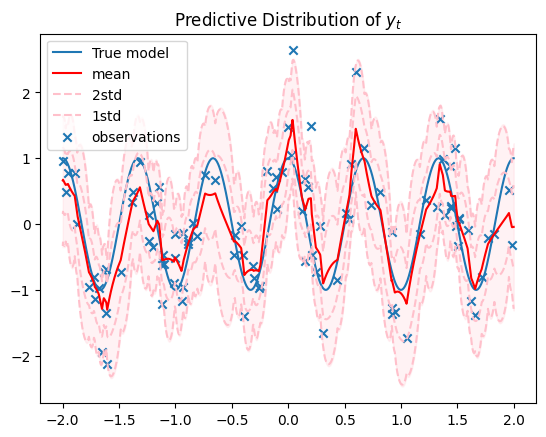

In [13]:
xt = np.squeeze(Xt.numpy())

plt.plot(xg,yg,label='True model')
plt.plot(xt,mt,label='mean',color='red')

plt.plot(xt,mt+1.96*st,label='2std',linestyle='--',color='pink')
plt.fill_between(xt, mt-2*st, mt+2*st,alpha=0.1,color='pink')
plt.plot(xt,mt-1.96*st,linestyle='--',color='pink')

plt.plot(xt,mt+st,label='1std',linestyle='--',color='pink')
plt.fill_between(xt, mt-2*st, mt+2*st,alpha=0.1,color='pink')
plt.plot(xt,mt-st,linestyle='--',color='pink')


plt.scatter(X,Y,marker='x',label='observations')
plt.title('Predictive Distribution of $y_t$')
plt.legend()

# Data generation 2

In [14]:
import random

# Uknown  generative model
def ff(x, a=1., b1=3, b2=2):
  return np.cos(b1*np.pi*x[0])+np.cos(b2*np.pi/4*x[1])

random.seed(42)
def get_ff_observation(ff):
  sigma_n = 0.5
  # Change the data generation to analize the predictive variance with uniform samples in the interval [-2,2] vs. no unifrom
  x = np.random.uniform(-2,2,2)
  ee = random.gauss(mu=0, sigma=sigma_n)
  return x, ff(x) + ee

# Train samples
n=100
X=[]
Y=[]
for n in range(100):
  x,y = get_ff_observation(ff)
  X.append(x)
  Y.append(y)

# Test samples
Xt = np.random.uniform(-2,2,(100,2))

# Compute model outputs
ft = np.array([ff(xx) for xx in Xt])
s = 0.5
Yt = ft+ np.array([random.gauss(mu=0, sigma=s) for ii in range(Xt.shape[0])]) # Add noise over example samples


In [15]:
X = torch.squeeze(torch.tensor(X)[:,None].double())
Y = torch.tensor(Y).double()
Xt = torch.squeeze(torch.tensor(Xt)[:,None].double())
Yt = torch.tensor(Yt).double()

<ipython-input-15-38cb502b4e54>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  X = torch.squeeze(torch.tensor(X)[:,None].double())


Now test the performance of the model for this new data set. Note that the problem is two-dimensional, so the whole model you have designed must work correctly with tensors with more than one input variable. Since we can't digest the predictive distribution now (X is not unidimensional) we will settle for calculating the test performance before and after learning the hyperparameters of the model. Write the necessary code to do this evaluation.

### SOLUTION

In [16]:
myGP = GaussianProcess()
myGP.fit(X,Y, hyperparam_fitting = False)
mt, st = myGP.predict(Xt)

# Compute MSE error
MSE_tst = np.mean((Yt-mt).numpy()**2)
print(MSE_tst)

0.8507831022198805


In [17]:
myGP.fit(X,Y)
mt, st = myGP.predict(Xt)

# Compute MSE error
MSE_tst = np.mean((Yt-mt).numpy()**2)
print(MSE_tst)

Iter 1/5000 - Loss: 233.782   gamma: 1.100   noise: 0.200
Iter 501/5000 - Loss: 136.600   gamma: 1.152   noise: 0.694
Iter 1001/5000 - Loss: 136.448   gamma: 0.817   noise: 0.748
Iter 1501/5000 - Loss: 136.448   gamma: 0.815   noise: 0.749
Iter 2001/5000 - Loss: 136.448   gamma: 0.815   noise: 0.749
Iter 2501/5000 - Loss: 136.448   gamma: 0.815   noise: 0.749
Iter 3001/5000 - Loss: 136.448   gamma: 0.815   noise: 0.749
Iter 3501/5000 - Loss: 136.448   gamma: 0.815   noise: 0.749
Iter 4001/5000 - Loss: 136.485   gamma: 0.818   noise: 0.744
Iter 4501/5000 - Loss: 136.488   gamma: 0.819   noise: 0.744
0.879050579602483
